## Introduction

This project is for the competition: https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

## Wrapper function

In [360]:
def plot_num_cat_relationship(df, x, y):
    plt.figure(figsize=[12, 6])
    for ind, cat in enumerate(np.unique(df[y].values), start=1):
        plt.subplot(1, 2, ind)
        sns.distplot(df[x].values[df[y].values == cat])
        plt.xlabel(str(cat))
    
### plot the relationship between categorical variables and the target variable
def plot_cat_tar_relationship(df, x, y):
    pd.crosstab(df[x], df[y]).apply(lambda x: x/np.sum(x), axis=1).plot(kind='bar', stacked=True,
                                                                                            rot=0, edgecolor=None)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('Percentage')
    
### calculate the anova value between categorical variables and target variable 
def cal_anova(df, x, y):
    from scipy.stats import f_oneway
    vectors = []
    for cat in np.unique(df[y].values):
        vectors.append(df[x].values[df[y].values == cat])
    
    return f_oneway(*vectors)

### calculate the chi squared test of independence between categorical variables
def cal_chi2(df, col_name=[]):
    from scipy.stats import chi2_contingency
    
    chi_mat = np.zeros([len(col_name), len(col_name)])
    
    for i in range(len(col_name)):
        for j in range(len(col_name)):
            if i == j:
                chi_mat[i, j] = 0
            else:
                chi_mat[i, j] = (1 - chi2_contingency(pd.crosstab(df[col_name[i]], df[col_name[j]]))[1])
    
    chi_mat = pd.DataFrame(chi_mat, columns=col_name, index=col_name)
    
    return chi_mat



### Get dataset ready for modeling 
def model_process(df, df_tr, num_col_name, cat_col_name, median_loanamount, median_loanamountterm):
    
    df['Gender'][df['Gender'].isnull()] = 'Male'
    df['Married'][df['Married'].isnull()] = 'Yes'
    df['Dependents'][df['Dependents'].isnull()] = '0'
    df['Self_Employed'][df['Self_Employed'].isnull()] = 'No'
    df['LoanAmount'].fillna(median_loanamount, inplace=True)
    df['Loan_Amount_Term'].fillna(median_loanamountterm, inplace=True)
    df['Loan_Amount_Term_mon'] = df['Loan_Amount_Term']/12
    df['Credit_History'].fillna(2, inplace=True)
    df['Credit_History'] = df['Credit_History'].astype(int)
    
    def label_encoder(df, col):
        from sklearn import preprocessing
        le = preprocessing.LabelEncoder()
        le.fit(df[col].values)

        return le

    def one_hot(df, col, label_encoder):
        from sklearn import preprocessing
        vec = label_encoder.transform(df[col].values).reshape([len(df[col]), 1])
        ohc = preprocessing.OneHotEncoder(sparse=False, n_values=len(label_encoder.classes_))
        ohc_df = ohc.fit_transform(vec)

        ohc_df = pd.DataFrame(ohc_df, columns=[col+'_'+str(cls) for cls in label_encoder.classes_], index=range(len(df[col])))
        return ohc_df
    
    ### New features
    df['Sum_income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    df['Loan_income_ratio'] = df['LoanAmount']/df['ApplicantIncome']
    ###
    
    X = df.ix[:, num_col_name]
    
    for cat in cat_col_name:
        X = pd.concat([X, one_hot(df, cat, label_encoder(df_tr, cat))], axis=1)
        
    y = df['Loan_Status'].apply(lambda x: 1 if x == 'N' else 0)
    
    return X, y

## Setup

In [361]:
### Load required packages
import numpy as np 
import pandas as pd 
import scipy as sp 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

seed = 100
np.random.seed(seed)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

In [362]:
### Load the dataset
df = pd.read_csv('D:/Dataset/Side_project_Loan_prediction/train_u6lujuX_CVtuZ9i.csv')
print(df.head())
print('\n', df.shape)

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

In [363]:
### Overview of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB
None


There are many features with NAs

#### Gender

In [364]:
print(df['Gender'].value_counts())

Male      489
Female    112
Name: Gender, dtype: int64


Since most of the people are Male, I would use "Male" to fill the NAs.

In [365]:
df['Gender'][df['Gender'].isnull()] = 'Male'

#### Married

In [366]:
print(df['Married'].value_counts())

Yes    398
No     213
Name: Married, dtype: int64


Since most of the people are married, I would use "Yes" to fill the NAs

In [367]:
df['Married'][df['Married'].isnull()] = 'Yes'

#### Dependents

In [368]:
print(df['Dependents'].value_counts())

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64


I would use 0 to fill the NAs

In [369]:
df['Dependents'][df['Dependents'].isnull()] = '0'

#### Self_Employed

In [370]:
print(df['Self_Employed'].value_counts())

No     500
Yes     82
Name: Self_Employed, dtype: int64


I would use "No" to fill the NAs.

In [371]:
df['Self_Employed'][df['Self_Employed'].isnull()] = 'No'

#### LoanAmount

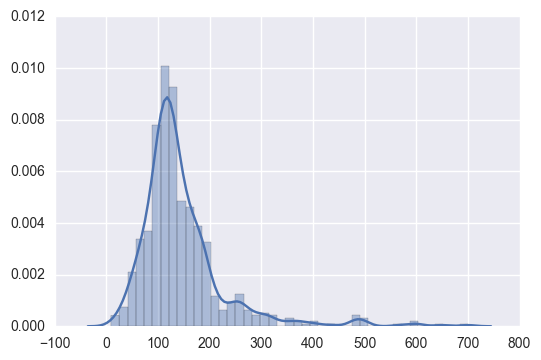

In [372]:
sns.distplot(df['LoanAmount'].values[~df['LoanAmount'].isnull()])

In [373]:
### Use median to fill the NAs
median_loanamount = np.median(df['LoanAmount'][~df['LoanAmount'].isnull()].values)
df['LoanAmount'].fillna(median_loanamount, inplace=True)

#### Loan_Amount_Term 

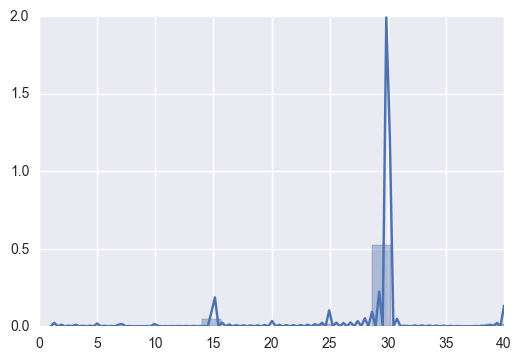

In [374]:
sns.distplot(df['Loan_Amount_Term'].values[~df['Loan_Amount_Term'].isnull()]/12)

In [375]:
### Use median to fill the NAs
median_loanamountterm = np.median(df['Loan_Amount_Term'][~df['Loan_Amount_Term'].isnull()].values)
df['Loan_Amount_Term'].fillna(median_loanamountterm, inplace=True)

In [376]:
### Transform the term to month
df['Loan_Amount_Term_mon'] = df['Loan_Amount_Term']/12

#### Credit_History

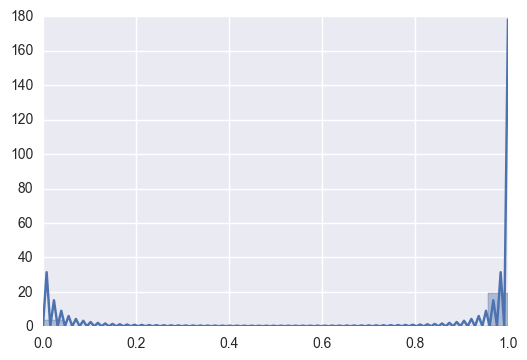

In [377]:
sns.distplot(df['Credit_History'].values[~df['Credit_History'].isnull()])

In [378]:
print(df['Credit_History'].value_counts())

1.0    475
0.0     89
Name: Credit_History, dtype: int64


In [379]:
### Since the NAs in this feature is more significant, I would try to assign them a new value
df['Credit_History'].fillna(2, inplace=True)

In [380]:
### Transform this feature to int
df['Credit_History'] = df['Credit_History'].astype(int)

#### Split the dataset to train and test

In [381]:
print(df['Loan_Status'].value_counts()/len(df))

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64


In [382]:
from sklearn.model_selection import train_test_split
df_tr, df_test = train_test_split(df, test_size=0.2, stratify=df['Loan_Status'], random_state=seed)

In [383]:
print(df_tr.shape)
print(df_test.shape)

df_tr.index = range(len(df_tr))
df_test.index = range(len(df_test))

(491, 14)
(123, 14)


## EDA

In [384]:
print(df_tr.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 14 columns):
Loan_ID                 491 non-null object
Gender                  491 non-null object
Married                 491 non-null object
Dependents              491 non-null object
Education               491 non-null object
Self_Employed           491 non-null object
ApplicantIncome         491 non-null int64
CoapplicantIncome       491 non-null float64
LoanAmount              491 non-null float64
Loan_Amount_Term        491 non-null float64
Credit_History          491 non-null int32
Property_Area           491 non-null object
Loan_Status             491 non-null object
Loan_Amount_Term_mon    491 non-null float64
dtypes: float64(4), int32(1), int64(1), object(8)
memory usage: 51.9+ KB
None


In [385]:
print(df_tr['Loan_Status'].value_counts())

Y    337
N    154
Name: Loan_Status, dtype: int64


#### ApplicantIncome

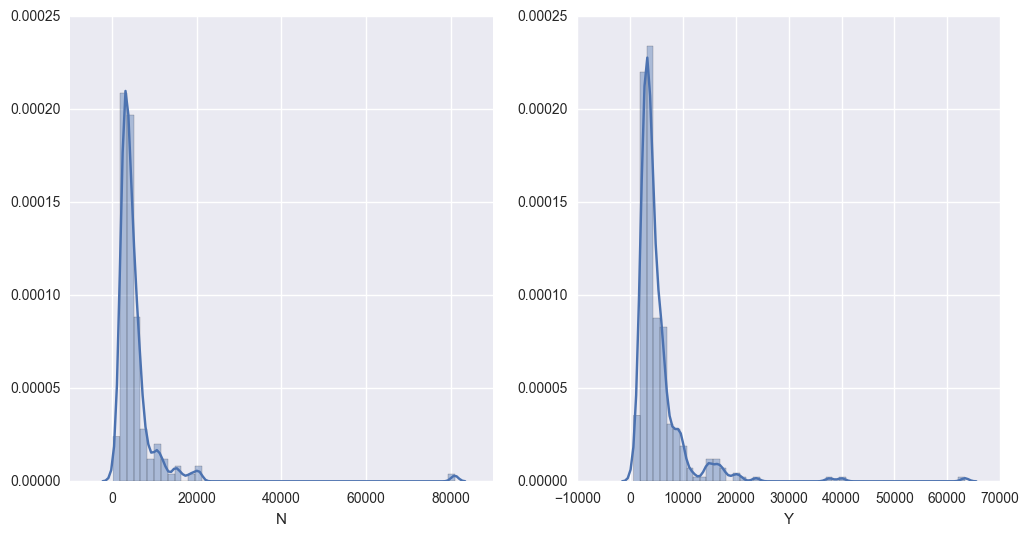

In [386]:
plot_num_cat_relationship(df_tr, 'ApplicantIncome', 'Loan_Status')

#### CoapplicantIncome

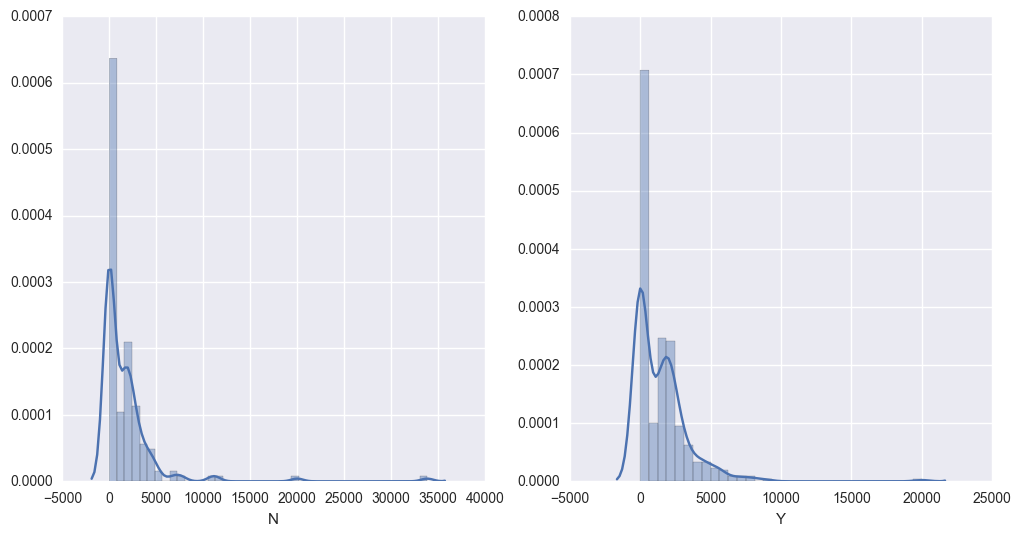

In [387]:
plot_num_cat_relationship(df_tr, 'CoapplicantIncome', 'Loan_Status')

#### LoanAmount

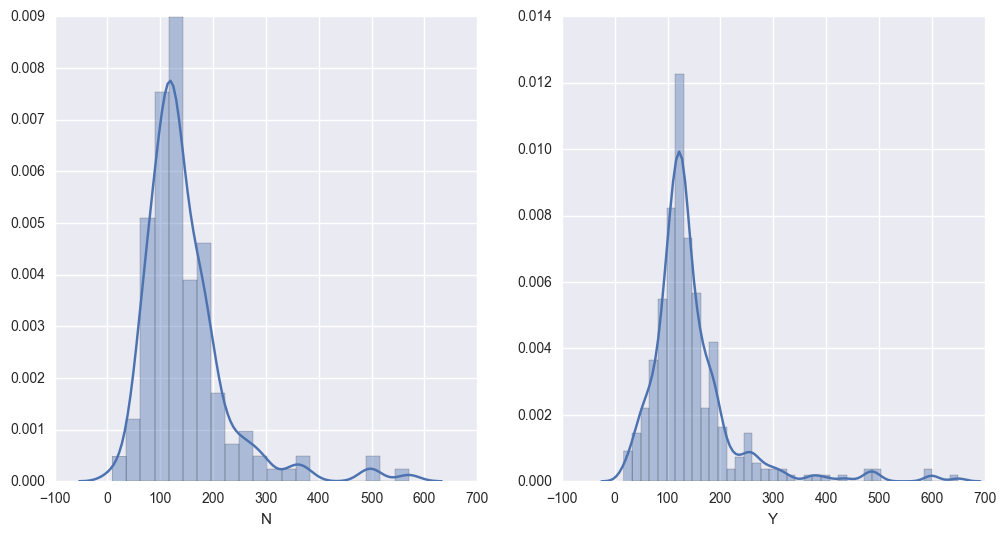

In [388]:
plot_num_cat_relationship(df_tr, 'LoanAmount', 'Loan_Status')

#### Loan_Amount_Term_mon

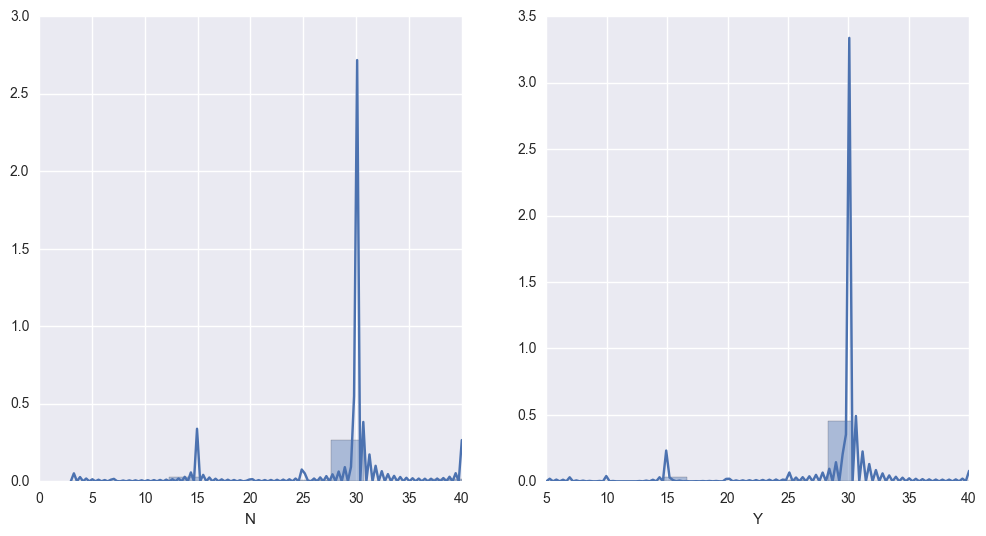

In [389]:
plot_num_cat_relationship(df_tr, 'Loan_Amount_Term_mon', 'Loan_Status')

#### Relationship of numerical variables with target variable 

In [390]:
anova_list = []
for num in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term_mon']:
    anova_list.append(cal_anova(df_tr, num, 'Loan_Status'))       
    
anova_dict = dict(zip(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term_mon'], anova_list))

num_col_name = []

for i in sorted(anova_dict, key=anova_dict.get, reverse=True):
    print(i, '\n', anova_dict[i])
    num_col_name.append(i)

CoapplicantIncome 
 F_onewayResult(statistic=0.95536901441762845, pvalue=0.32883970938310747)
Loan_Amount_Term_mon 
 F_onewayResult(statistic=0.056400748512748129, pvalue=0.81237737061573134)
LoanAmount 
 F_onewayResult(statistic=0.047023467066639298, pvalue=0.82841650259850574)
ApplicantIncome 
 F_onewayResult(statistic=0.0018074575233169301, pvalue=0.96610614244680293)


In [391]:
num_col_name

['CoapplicantIncome', 'Loan_Amount_Term_mon', 'LoanAmount', 'ApplicantIncome']

#### Gender

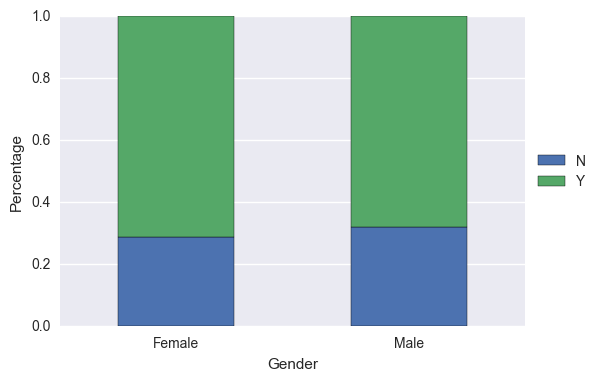

In [392]:
plot_cat_tar_relationship(df_tr, 'Gender', 'Loan_Status')

#### Married

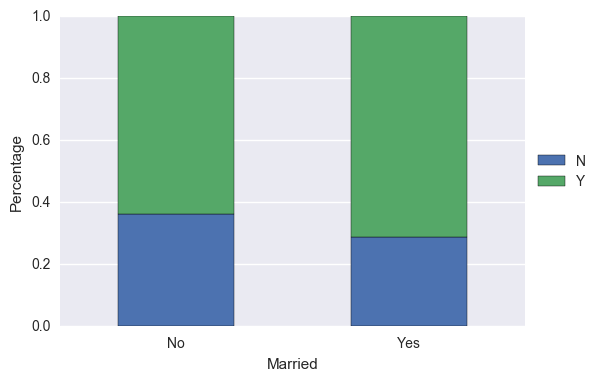

In [393]:
plot_cat_tar_relationship(df_tr, 'Married', 'Loan_Status')

#### Dependents

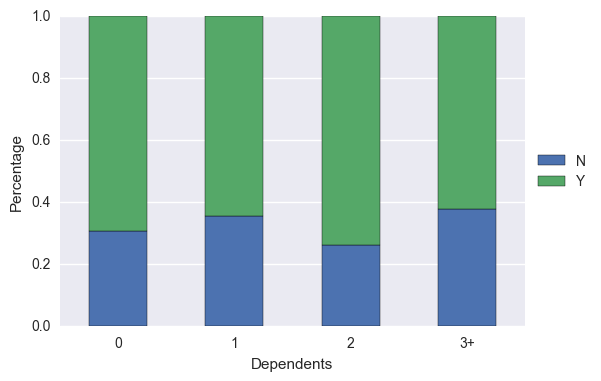

In [394]:
plot_cat_tar_relationship(df_tr, 'Dependents', 'Loan_Status')

#### Education

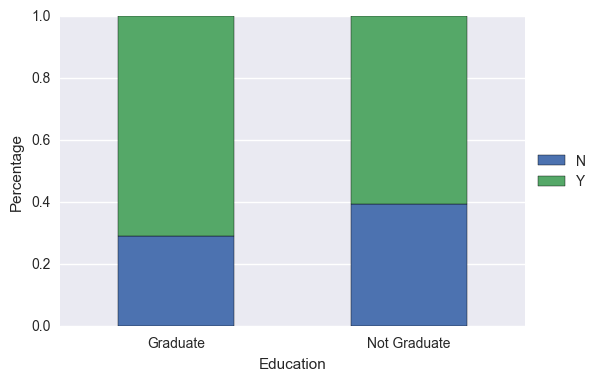

In [395]:
plot_cat_tar_relationship(df_tr, 'Education', 'Loan_Status')

#### Self_Employed

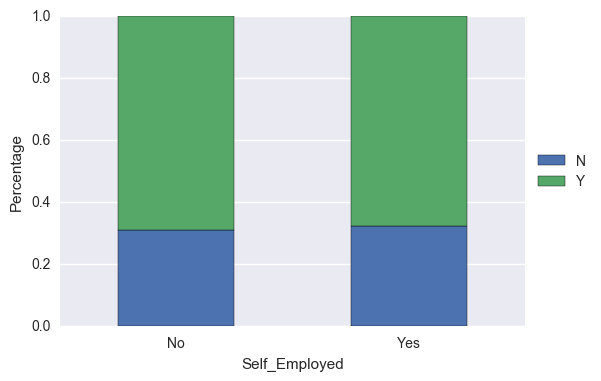

In [396]:
plot_cat_tar_relationship(df_tr, 'Self_Employed', 'Loan_Status')

#### Credit_History

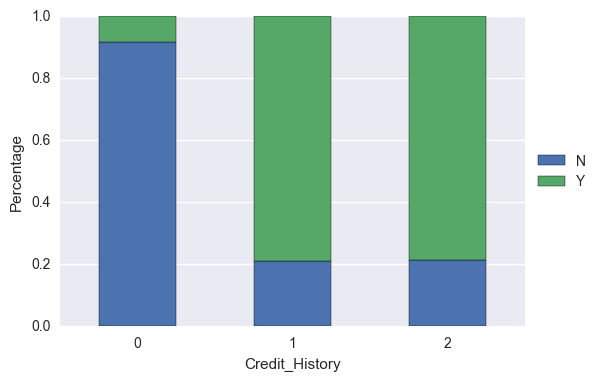

In [397]:
plot_cat_tar_relationship(df_tr, 'Credit_History', 'Loan_Status')

#### Property_Area

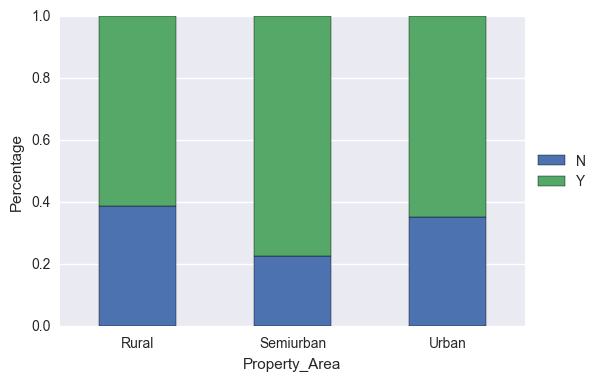

In [398]:
plot_cat_tar_relationship(df_tr, 'Property_Area', 'Loan_Status')

#### Relationships of categorical variables with target variable 

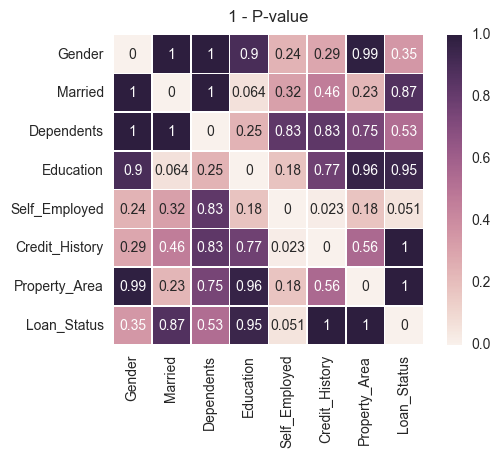

In [399]:
sns.heatmap(cal_chi2(df_tr, ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']
                    ), annot=True, linewidth=0.5, square=True)
plt.title('1 - P-value', y=1.02)

In [400]:
cat_col_name = list(cal_chi2(df_tr,
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status'])['Loan_Status'].sort_values(ascending=False).index)[:-1]

## Modeling

In [401]:
num_col_name

['CoapplicantIncome', 'Loan_Amount_Term_mon', 'LoanAmount', 'ApplicantIncome']

In [402]:
cat_col_name

['Credit_History',
 'Property_Area',
 'Education',
 'Married',
 'Dependents',
 'Gender',
 'Self_Employed']

In [403]:
X, y = model_process(df_tr, df_tr, num_col_name, cat_col_name, median_loanamount, median_loanamountterm)

In [404]:
X = X.values
y = y.values

In [405]:
print(X.shape)

(491, 22)


#### Random Forest

In [406]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier()
print(cross_val_score(model, X[:, 0:18], y, cv=10, scoring='accuracy'))

[ 0.74        0.72        0.78        0.82        0.71428571  0.85714286
  0.75510204  0.70833333  0.72916667  0.79166667]


#### XGB

In [407]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

model = XGBClassifier()
print(cross_val_score(model, X[:, 0:18], y, cv=10, scoring='accuracy'))

[ 0.72        0.8         0.84        0.8         0.7755102   0.85714286
  0.71428571  0.75        0.83333333  0.77083333]


#### SVM

In [408]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

model = SVC()
print(cross_val_score(model, X[:, 0:18], y, cv=10, scoring='accuracy'))

[ 0.68        0.7         0.68        0.7         0.69387755  0.69387755
  0.69387755  0.66666667  0.6875      0.6875    ]


#### Logistic regression

In [409]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

model = LogisticRegressionCV()
print(cross_val_score(model, X[:, 0:18], y, cv=10, scoring='accuracy'))

[ 0.74        0.78        0.84        0.84        0.73469388  0.91836735
  0.75510204  0.77083333  0.83333333  0.77083333]


## Evaluation

In [410]:
X_test, y_test = model_process(df_test, df_tr, num_col_name, cat_col_name, median_loanamount, median_loanamountterm)

In [411]:
X_test = X_test.values
y_test = y_test.values

In [412]:
print(X_test.shape)

(123, 22)


#### Logistic regressionCV

In [413]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

model = LogisticRegressionCV(cv=10)
model.fit(X[:, 0:18], y)
print(accuracy_score(y_test, model.predict(X_test[:, 0:18])))

0.829268292683


#### XGB

In [414]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(n_estimators=150, learning_rate=0.04, max_depth=5, )
model.fit(X[:, 0:18], y)
print(accuracy_score(y_test, model.predict(X_test[:, 0:18])))

0.80487804878


#### Random Forest

In [415]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=500)
model.fit(X[:, 0:18], y)
print(accuracy_score(y_test, model.predict(X_test[:, 0:18])))

0.80487804878


#### AdaBoostClassifier

In [416]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

model = AdaBoostClassifier(n_estimators=100)
model.fit(X[:, 0:18], y)
print(accuracy_score(y_test, model.predict(X_test[:, 0:18])))

0.80487804878


#### Deep Learning

In [417]:
""""
from keras.models import Sequential
from keras.layers import Dense

np.random.seed(seed)

# create model
model = Sequential()
model.add(Dense(15, input_dim=X.shape[1], init='normal', activation='relu'))
model.add(Dense(10, init='normal', activation='relu'))
model.add(Dense(3, init='normal', activation='relu'))
model.add(Dense(1, init='normal', activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X, y, nb_epoch=150, batch_size=10, verbose=0)
print('done!')
"""

'"\nfrom keras.models import Sequential\nfrom keras.layers import Dense\n\nnp.random.seed(seed)\n\n# create model\nmodel = Sequential()\nmodel.add(Dense(15, input_dim=X.shape[1], init=\'normal\', activation=\'relu\'))\nmodel.add(Dense(10, init=\'normal\', activation=\'relu\'))\nmodel.add(Dense(3, init=\'normal\', activation=\'relu\'))\nmodel.add(Dense(1, init=\'normal\', activation=\'sigmoid\'))\n\n# Compile model\nmodel.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n\n# Fit the model\nmodel.fit(X, y, nb_epoch=150, batch_size=10, verbose=0)\nprint(\'done!\')\n'

In [418]:
#model.evaluate(X, y)

In [419]:
#print(accuracy_score(y_test, model.predict_classes(X_test)))

Not as good as basic model

## Test on real test dataset

In [420]:
### Load dataset
df_test_real = pd.read_csv('D:/Dataset/Side_project_Loan_prediction/test_Y3wMUE5_7gLdaTN.csv')
print(df_test_real.shape)

(367, 12)


In [421]:
df_total = pd.concat([df_tr, df_test], axis=0)
print(df_total.shape)

df_total.index = range(len(df_total))

(614, 16)


In [422]:
X, y = model_process(df_total, df_tr, num_col_name, cat_col_name, median_loanamount, median_loanamountterm)

In [423]:
print(X.shape)
print(y.shape)

X = X.values
y = y.values

(614, 22)
(614,)


In [424]:
### Get dataset ready for modeling 
def model_process(df, df_tr, num_col_name, cat_col_name, median_loanamount, median_loanamountterm):
    
    df['Gender'][df['Gender'].isnull()] = 'Male'
    df['Married'][df['Married'].isnull()] = 'Yes'
    df['Dependents'][df['Dependents'].isnull()] = '0'
    df['Self_Employed'][df['Self_Employed'].isnull()] = 'No'
    df['LoanAmount'].fillna(median_loanamount, inplace=True)
    df['Loan_Amount_Term'].fillna(median_loanamountterm, inplace=True)
    df['Loan_Amount_Term_mon'] = df['Loan_Amount_Term']/12
    df['Credit_History'].fillna(2, inplace=True)
    df['Credit_History'] = df['Credit_History'].astype(int)
    
    def label_encoder(df, col):
        from sklearn import preprocessing
        le = preprocessing.LabelEncoder()
        le.fit(df[col].values)

        return le

    def one_hot(df, col, label_encoder):
        from sklearn import preprocessing
        vec = label_encoder.transform(df[col].values).reshape([len(df[col]), 1])
        ohc = preprocessing.OneHotEncoder(sparse=False, n_values=len(label_encoder.classes_))
        ohc_df = ohc.fit_transform(vec)

        ohc_df = pd.DataFrame(ohc_df, columns=[col+'_'+str(cls) for cls in label_encoder.classes_], index=range(len(df[col])))
        return ohc_df
    
    ### New features
    df['Sum_income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    #df['Loan_income_ratio'] = df['LoanAmount']/df['ApplicantIncome']
    ###
    
    X = df.ix[:, num_col_name]
    
    for cat in cat_col_name:
        X = pd.concat([X, one_hot(df, cat, label_encoder(df_tr, cat))], axis=1)
        
    #y = df['Loan_Status'].apply(lambda x: 1 if x == 'N' else 0)
    
    return X

In [425]:
X_test_real = model_process(df_test_real, df_total, num_col_name, cat_col_name, median_loanamount, median_loanamountterm)
X_test_real = X_test_real.values

#### Build model

In [426]:
"""
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(n_estimators=120, learning_rate=0.05)
model.fit(X[:, 0:15], y)
"""

'\nfrom xgboost import XGBClassifier\nfrom sklearn.metrics import accuracy_score\n\nmodel = XGBClassifier(n_estimators=120, learning_rate=0.05)\nmodel.fit(X[:, 0:15], y)\n'

In [427]:
# best for original features
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(n_estimators=150, learning_rate=0.04, max_depth=5)
model.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.04, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [428]:
#model.feature_importances_
#model_process(df_test_real, df_total, num_col_name+['Sum_income', 'Loan_income_ratio'], cat_col_name, median_loanamount, median_loanamountterm).columns

In [429]:
#feature_importance = dict(zip(model_process(df_test_real, df_total, num_col_name+['Sum_income', 'Loan_income_ratio'], cat_col_name, median_loanamount, median_loanamountterm).columns,
#        model.feature_importances_))

#for i in sorted(feature_importance, key=feature_importance.get, reverse=True):
#    print(i, feature_importance[i])

In [430]:
"""
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

model = LogisticRegressionCV(cv=10)
model.fit(X[:, 0:18], y)
"""

'\nfrom sklearn.linear_model import LogisticRegressionCV\nfrom sklearn.metrics import accuracy_score\n\nmodel = LogisticRegressionCV(cv=10)\nmodel.fit(X[:, 0:18], y)\n'

#### Making submission

In [431]:
submission = pd.read_csv('D:/Dataset/Side_project_Loan_prediction/Sample_Submission_ZAuTl8O_FK3zQHh.csv')
print(submission.head())

Empty DataFrame
Columns: [Loan_ID, Loan_Status]
Index: []


In [432]:
submission['Loan_ID'] = df_test_real['Loan_ID']
submission['Loan_Status'] = model.predict(X_test_real)
submission['Loan_Status'] = submission['Loan_Status'].apply(lambda x: 'N' if x == 1 else 'Y')

In [433]:
print(submission.head())

    Loan_ID Loan_Status
0  LP001015           Y
1  LP001022           Y
2  LP001031           Y
3  LP001035           Y
4  LP001051           Y


In [434]:
submission.to_csv('D:/Dataset/Side_project_Loan_prediction/sample_submission.csv', index=False, index_label=False)